In [1]:
import numpy as np
import sympy as sm
import sympy.physics.mechanics as me
from opty import Problem
from opty.utils import parse_free
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import patches

In [2]:
N, A1 = sm.symbols('N A1', cls = me.ReferenceFrame)
t = me.dynamicsymbols._t
O, P1, P2 = sm.symbols('O P1 P2', cls = me.Point)
O.set_vel(N, 0)
q1, q2, u1, u2, F = me.dynamicsymbols('q1 q2 u1 u2 F')
l1, m1, m2, g, iZZ1 = sm.symbols('l1, m1, m2, g, iZZ1')

A1.orient_axis(N, q2, N.z)
A1.set_ang_vel(N, u2*N.z)

P1.set_pos(O, q1 * N.x)
P2.set_pos(P1, l1 * A1.x)
P2.v2pt_theory(P1, N, A1)

P1a = me.Particle('P1a', P1, m1)

I1 = me.inertia(A1, 0, 0, iZZ1)
P2a = me.RigidBody('P2a', P2, A1, m2, (I1, P2))

bodies = [P1a, P2a]

loads = [(P1, F * N.x - m1*g*N.y), (P2, - m2*g*N.y)]
kd = sm.Matrix([q1.diff(t) - u1, q2.diff(t) - u2])

q_ind = [q1, q2]
u_ind = [u1, u2]

KM = me.KanesMethod(N, q_ind=q_ind,
                    u_ind=u_ind,
                    kd_eqs=kd)

fr, frstar = KM.kanes_equations(bodies, loads=loads)
eom = kd.col_join(fr + frstar)
sm.pprint(sm.trigsimp(eom))

⎡                                        d                                     ↪
⎢                               -u₁(t) + ──(q₁(t))                             ↪
⎢                                        dt                                    ↪
⎢                                                                              ↪
⎢                                        d                                     ↪
⎢                               -u₂(t) + ──(q₂(t))                             ↪
⎢                                        dt                                    ↪
⎢                                                                              ↪
⎢        2                                  d                     d            ↪
⎢l₁⋅m₂⋅u₂ (t)⋅cos(q₂(t)) + l₁⋅m₂⋅sin(q₂(t))⋅──(u₂(t)) - (m₁ + m₂)⋅──(u₁(t)) +  ↪
⎢                                           dt                    dt           ↪
⎢                                                                              ↪
⎢                           

In [3]:
h = sm.symbols('h')

state_symbols = tuple((*q_ind, *u_ind))
constant_symbols = (l1, m1, m2, g, iZZ1)
specified_symbols = (F, )

target_angle = np.pi/2.0
num_nodes = 300

duration = (num_nodes - 1) * h
interval_value = h

In [4]:
par_map = {}
par_map[l1] = 2.0
par_map[m1] = 1.0
par_map[m2] = 1.0
par_map[g] = 9.81
par_map[iZZ1] = 2.0

def obj(free):
    '''
    Minimize h, the time interval between nodes.
    '''
    return free[-1]


def obj_grad(free):
    '''
    Gradient of the objective function.
    '''
    grad = np.zeros_like(free)
    grad[-1] = 1.0

    return grad

In [5]:
initial_state_constraints = {
    q1: 0.0,
    q2: -np.pi/2.0,
    u1: 0.0,
    u2: 0.0,
}

final_state_constraints = {
    q2: target_angle,
    u1: 0.0,
    u2: 0.0,
}

instance_constraints = (tuple(xi.subs({t: 0}) - xi_val for xi, xi_val in
                              initial_state_constraints.items()) +
                        tuple(xi.subs({t: duration}) - xi_val for xi, xi_val in
                              final_state_constraints.items()))

In [6]:
bounds = {F: (-150.0, 150.0),
          q1: (-5.0, 5.0),
          h: (0.0, 1.0)
}

In [7]:
prob = Problem(
    obj, 
    obj_grad,
    eom, 
    state_symbols,
    num_nodes,
    interval_value,
    known_parameter_map = par_map,
    instance_constraints = instance_constraints,
    time_symbol = t,
    bounds = bounds
)

# Initial guess.
initial_guess = np.zeros(prob.num_free)
initial_guess[1*num_nodes:2*num_nodes] = np.linspace(-target_angle,
                                                     target_angle,
                                                     num=num_nodes)
# initial_guess[2*num_nodes:3*num_nodes] = np.linspace(-target_angle,
                                                    #  target_angle,
                                                    #  num=num_nodes)
# initial_guess[6*num_nodes:7*num_nodes] = 50.0*np.ones(num_nodes)
initial_guess[-1] = 0.01


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:    11967
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1501
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      601
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1203
Total number of inequality c

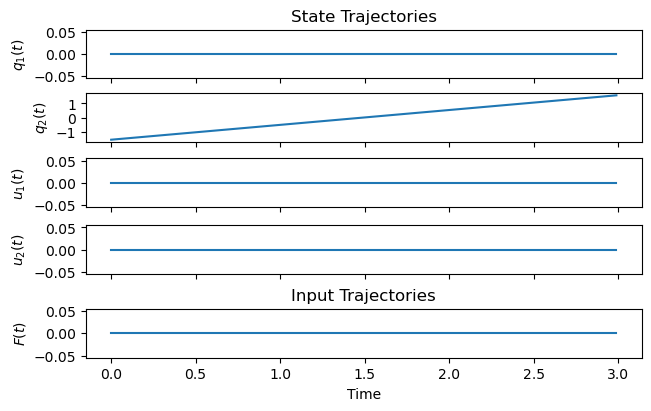

In [8]:
_ = prob.plot_trajectories(initial_guess)

# Find the optimal solution.
# As initial guess the solution of a previous run, stored in
# 'two_link_pendulum_on_a_cart_solution.npy' is used

# initial_guess = np.load('two_link_pendulum_on_a_cart_solution.npy')
solution, info = prob.solve(initial_guess)
print('Message from optimizer:', info['status_msg'])
print('Iterations needed', len(prob.obj_value))
print(f"Objective value {solution[-1]: .3e}")

In [9]:
np.array(solution)

array([-4.37874217e-34, -7.91431661e-04, -2.37427572e-03, ...,
       -1.49972147e+02, -1.49972495e+02,  2.65259446e-03], shape=(1501,))

In [10]:
# np.save('pendulum_on_a_cart_solution.npy', solution)

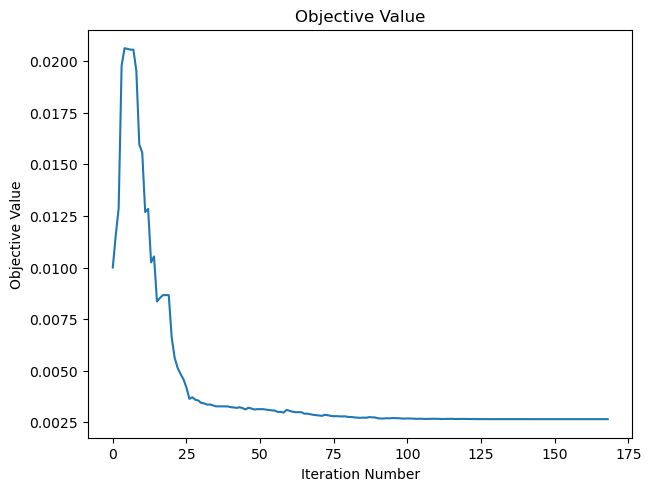

In [11]:
_ = prob.plot_objective_value()

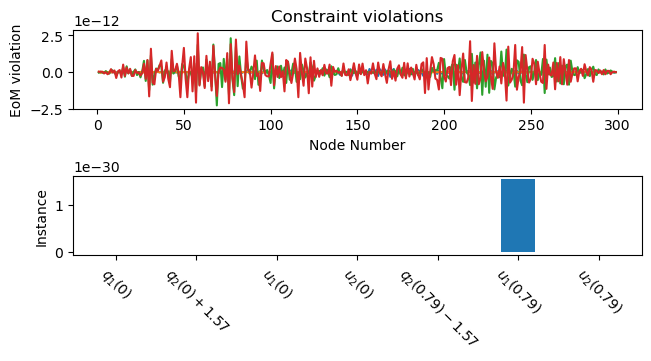

In [12]:
_ = prob.plot_constraint_violations(solution)

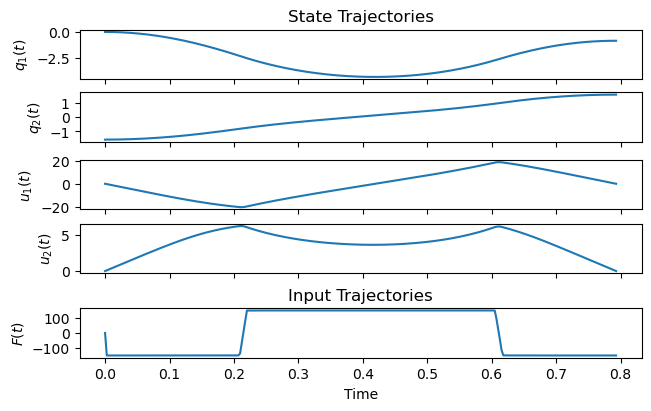

In [13]:
_ = prob.plot_trajectories(solution)

num nodes 75


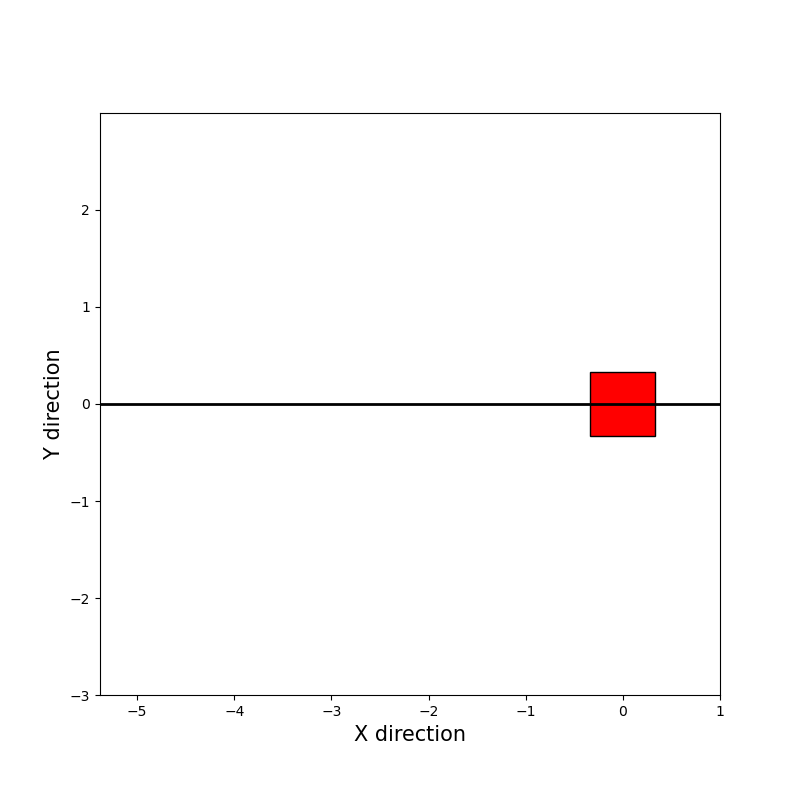

In [14]:
%matplotlib widget
state_sol, _, _, h_var = parse_free(solution, len(state_symbols),
        len(specified_symbols),num_nodes, variable_duration=True)
state_sol1 = state_sol.T[::4, :]
num_nodes = state_sol1.shape[0]
print('num nodes', num_nodes)
solution = list(state_sol1.T.flatten()) + [h_var]

P1_x = np.empty(num_nodes)
P1_y = np.empty(num_nodes)
P2_x = np.empty(num_nodes)
P2_y = np.empty(num_nodes)
# P3_x = np.empty(num_nodes)
# P3_y = np.empty(num_nodes)

P1_loc = [me.dot(P1.pos_from(O), uv) for uv in [N.x, N.y]]
P2_loc = [me.dot(P2.pos_from(O), uv) for uv in [N.x, N.y]]
# P3_loc = [me.dot(P3.pos_from(O), uv) for uv in [N.x, N.y]]

qL = q_ind + u_ind
pL_vals = list(constant_symbols)
P1_loc_lam = sm.lambdify(qL + pL_vals, P1_loc, cse=True)
P2_loc_lam = sm.lambdify(qL + pL_vals, P2_loc, cse=True)
# P3_loc_lam = sm.lambdify(qL + pL_vals, P3_loc, cse=True)

for i in range(num_nodes):
    q_1 = solution[i]
    q_2 = solution[i + num_nodes]
    # q_3 = solution[i + 2 * num_nodes]
    u_1 = solution[i + 2 * num_nodes]
    u_2 = solution[i + 3 * num_nodes]
    # u_3 = solution[i + 5 * num_nodes]
    P1_x[i], P1_y[i] = P1_loc_lam(q_1, q_2, u_1, u_2,
                                  *list(par_map.values()))
    P2_x[i], P2_y[i] = P2_loc_lam(q_1, q_2, u_1, u_2,
                                  *list(par_map.values()))
    # P3_x[i], P3_y[i] = P3_loc_lam(q_1, q_2, q_3, u_1, u_2, u_3,
    #                               *list(par_map.values()))


# needed to give the picture the right size.
xmin = min(np.min(P1_x), np.min(P2_x)) #, np.min(P3_x))
xmax = max(np.max(P1_x), np.max(P2_x)) #, np.max(P3_x))
ymin = min(np.min(P1_y), np.min(P2_y)) #, np.min(P3_y))
ymax = max(np.max(P1_y), np.max(P2_y)) #, np.max(P3_y))

width, height = par_map[l1]/3., par_map[l1]/3.


def animate_pendulum(time, P1_x, P1_y, P2_x, P2_y):

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'aspect': 'equal'})

    ax.axis('on')
    ax.set_xlim(xmin - 1., xmax + 1.)
    ax.set_ylim(ymin - 1., ymax + 1.)

    ax.set_xlabel('X direction', fontsize=15)
    ax.set_ylabel('Y direction', fontsize=15)
    ax.axhline(0, color='black', lw=2)

    line1, = ax.plot([], [], 'o-', lw=0.5, color='blue')
    line2, = ax.plot([], [], 'o-', lw=0.5, color='green')

    recht = patches.Rectangle((P1_x[0] - width/2, P1_y[0] - height/2),
                              width=width, height=height, fill=True,
                              color='red', ec='black')
    ax.add_patch(recht)
    return fig, ax, line1, line2, recht


duration = (num_nodes - 1) * solution[-1] *4
times = np.linspace(0.0, duration, num_nodes)
fig, ax, line1, line2, recht = animate_pendulum(times, P1_x, P1_y, P2_x, P2_y)


def animate(i):
    message = (f'running time {times[i]: .2f} sec')
    ax.set_title(message, fontsize=15)
    recht.set_xy((P1_x[i] - width/2., P1_y[i] - height/2.))

    wert_x = [P1_x[i], P2_x[i]]
    wert_y = [P1_y[i], P2_y[i]]
    line1.set_data(wert_x, wert_y)

    # wert_x = [P2_x[i], P3_x[i]]
    # wert_y = [P2_y[i], P3_y[i]]
    line2.set_data(wert_x, wert_y)
    return line1, line2,


anim = animation.FuncAnimation(fig, animate, frames=num_nodes,
                               interval=solution[-1]*1000.0 * 4)